# 듀얼 모멘텀 + 엉성한 손절매

| 항목  |      설명      |
|------|:----------- -:|
| 스타일 |  듀얼 모멘텀 |
| 기대 CAGR | 10-15%   |
| 매수 전략 | S&P 500, Euro Stoxx, Nikkei, Kospi 중 최근 6개월간 가장 많이 상승한 지수를 추종하는 ETF에 투자 |
| | 그런데 4개 지수 모두 6개월 수익률이 예금금리 이하로 하락하면 모든 ETF매도 후 현금 보유. |
| 매도 전략 | 월 1회 리밸런싱 |
| | 단 평단가의 15%이상 폭락하면 언제든지 손절매 |

In [1]:
from lib.utils.logging import configure_logger
%load_ext autoreload
%autoreload 2
configure_logger()

## Data preparation

이전 듀얼 모멘텀 전략과 동일한 테이터를 사용한다.

In [ ]:
from lib.utils.data_utils import load_data, sync_market_days
import investpy

kospi_df = load_data('^KS11')
nikkei_df = load_data('^N225')
snp_df = load_data('^GSPC')

# (중요!!) 서로 다른 거래소의 종목 혹은 지수로 포트폴리오를 구성하는 경우 거래일의 교집합을 사용합니다.
kospi_df, nikkei_df, snp_df = sync_market_days(kospi_df, nikkei_df, snp_df)

## Develope your strategy

각 지표(종목)의 최근 6개월 모멘텀을 비교해서 가장 높은 종목으로 포트폴리오를 유지합니다. 
의사코드롤 표현하면 아래와 같습니다.

    if cur_position.rate_of_change < stop_loss:
        sell(cur_position)
        return
    
    securiy = get_the_best_security()
    if security.rate_of_change < saving_interest:
        sell(cur_position)
        return
        
    if cur_position != security:
        sell(cur_position)
        buy(security)
        return


## Run back-test.

In [3]:
import backtrader as bt

from lib.strategies.dual_momentum_strategy import DualmomentumStrategyWithNaiveStopLoss
from lib.utils.runtime_util import create_and_configure_cerebro

# Create a backtest runtime.
initial_cash = 1000000
cerebro = create_and_configure_cerebro(
    # 고정된 비율 이상 하락할때 손절매로직을 추가한 전략.
    DualmomentumStrategyWithNaiveStopLoss,
    {
        bt.feeds.PandasData(dataname=kospi_df): dict(name='KOSPI'),
        bt.feeds.PandasData(dataname=nikkei_df): dict(name='NIKKEI225'),
        bt.feeds.PandasData(dataname=snp_df): dict(name='S&P500')
    },
    initial_cash=initial_cash,
    # 기본값이 -15%이지만 가시성을 위해 설정.
    strategy_params=dict(buy_margin=0.02, momentum_period=120, saving_interest=0.02, stop_loss=-0.15)
)

# Run it!
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
dm_res = cerebro.run()
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
INFO - [2011-08-09] Position price: 2152.85009765625, Cur price: 1801.3499755859375. Stop Loss!
INFO - [2020-03-09] Position price: 3280.610107421875, Cur price: 2746.56005859375. Stop Loss!
Final Portfolio Value: 6912817.14


## Visualize your strategy

<IPython.core.display.Javascript object>


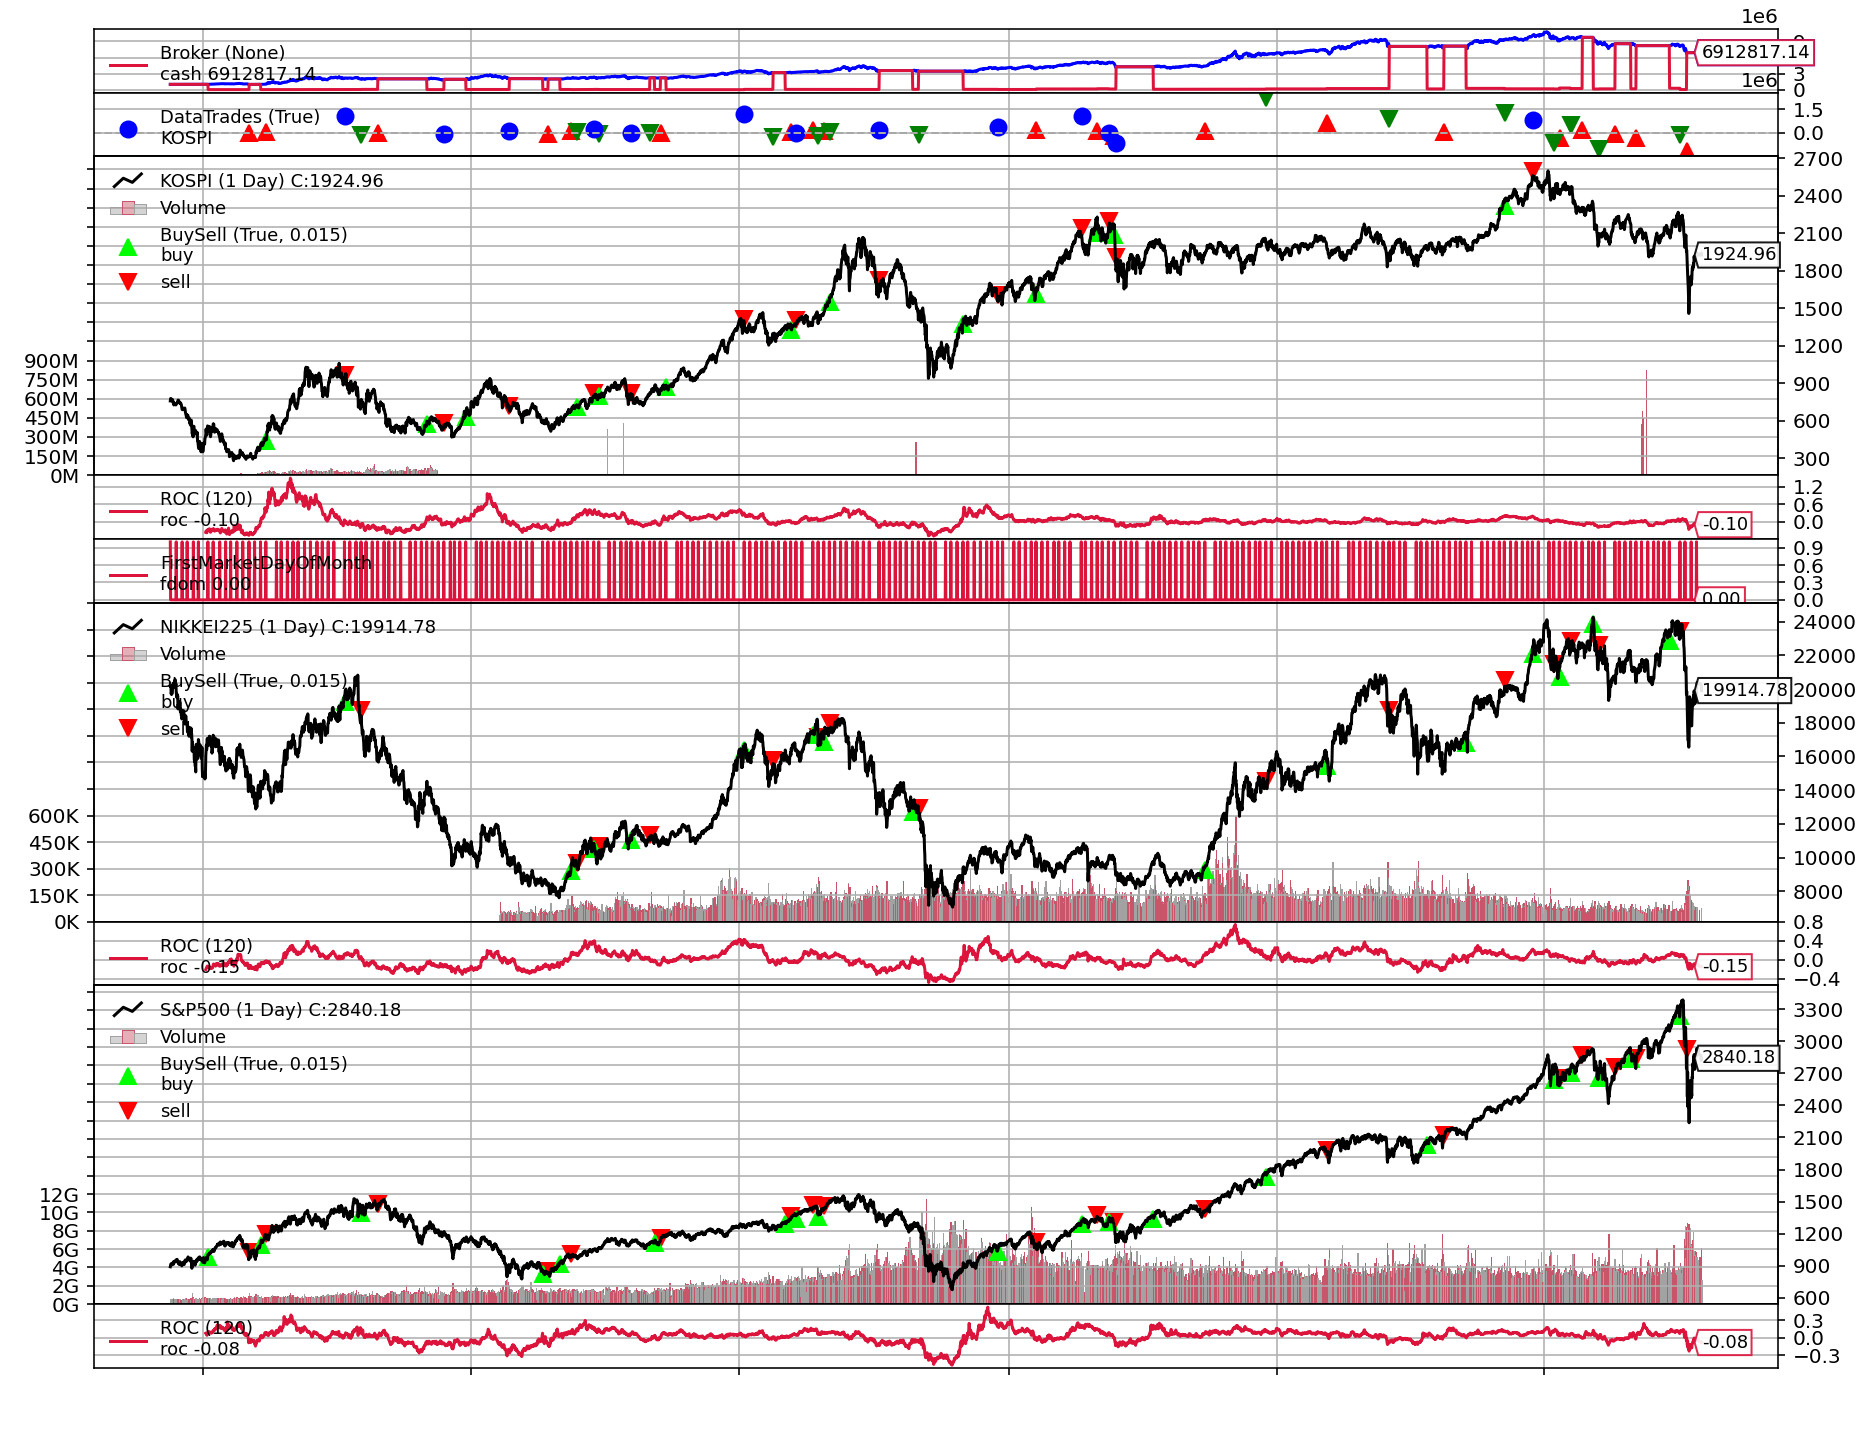

[[<Figure size 936x720 with 12 Axes>]]

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (13,10)
cerebro.plot()

or 
## Analyze the performance by yourself.

In [5]:
%matplotlib inline
import empyrical as ep
import pandas as pd

from lib.utils.analyzer_utils import get_annual_return_analysis_df, get_pos_values_analysis_df, get_default_perf_analysis_df

pd.set_option('float_format', '{:.3f}'.format)

dm_annual_return_df = get_annual_return_analysis_df(dm_res[0])
dm_pos_values_df = get_pos_values_analysis_df(dm_res[0])
dm_perf_report_df = get_default_perf_analysis_df(dm_res[0], 'Dual Momentum (stop-loss)')
dm_perf_report_df

,initial_value,final_value,period_start,period_end,best_year,worst_yaer,mean,stddev,sharpe_ratio,mdd,cagr
Dual Momentum (stop-loss),1000000.000,6912817.140,1997-07-01,2020-05-14,0.620,-0.237,0.104,0.223,0.411,37.571,0.088


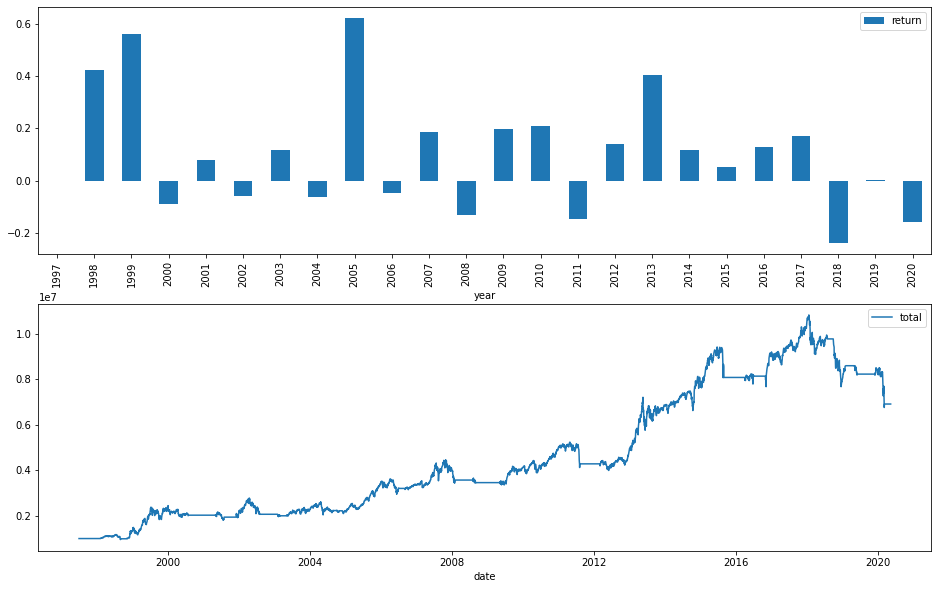

In [6]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from datetime import date
import matplotlib.dates as mdates


plt.rcParams["figure.figsize"] = (16,10)
fig = plt.figure()
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

dm_annual_return_df.plot.bar(ax=ax1)
dm_pos_values_df[['total']].plot(ax=ax2)

아주 엉성하고 무식한 손절매 로직을 하나 추가해서 MDD를 꽤 큰폭으로 제한할 수 있었다. 
실제로 손절매가 작동한 것은 23년동안 단 두번으로 극히 이례적인 케이스에서만 동작하고 대부분의 기간동안은 기존 듀얼모멘텀의 로직에 영향을 주지 않을 수 있었다. 듀얼모멘텀 전략 자체가 매월 리밸런싱을 하고 이때 종목간 과거 6개월의 수익률, 예금 금리를 비교하여 손절매에 준하는 행위를 하고 있기 때문에 극단적인 폭락만을 방지하고자 했다.

-15%의 고정비율 손절매를 적용했는데도 MDD가 그 두배가 넘게 나오는 이유는 하락장에서 종가기준 매도주문을 내도 backtrader 라이브러리에서 처리되는 주문 체결 시점의 가격은 그보다 훨씬 낮기 때문이다. 

# Benchmark test

벤치마크를 위해 바로 이전의 듀얼 모멘텀 테스트 결과와 대조해본다.

In [7]:
# Scenario 1
from lib.strategies.dual_momentum_strategy import DualmomentumStrategy
from lib.utils.runtime_util import create_and_configure_cerebro

# Create a backtest runtime.
initial_cash = 1000000
cerebro = create_and_configure_cerebro(
    DualmomentumStrategy,
    {
        bt.feeds.PandasData(dataname=kospi_df): dict(name='KOSPI'),
        bt.feeds.PandasData(dataname=nikkei_df): dict(name='NIKKEI225'),
        bt.feeds.PandasData(dataname=snp_df): dict(name='S&P500')
    },
    initial_cash=initial_cash,
    strategy_params=dict(buy_margin=0.02, momentum_period=120, saving_interest=0.02)
)

# Run it!
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
dm_org_res = cerebro.run()
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

dmorg_annual_return_df = get_annual_return_analysis_df(dm_org_res[0])
dmorg_pos_values_df = get_pos_values_analysis_df(dm_org_res[0])
dmorg_perf_report_df = get_default_perf_analysis_df(dm_org_res[0], 'Dual Momentum (org)')

Starting Portfolio Value: 1000000.00
Final Portfolio Value: 6030559.93


In [ ]:
# Scenario 1
from lib.strategies.sma_momentum_strategy import SMAMomentumStrategy
from lib.utils.analyzer_utils import get_annual_return_analysis_df, get_default_perf_analysis_df, get_pos_values_analysis_df
kospi_cerebro = create_and_configure_cerebro(
    SMAMomentumStrategy,
    {
        bt.feeds.PandasData(dataname=kospi_df): dict(name='KOSPI'),
    },
    strategy_params=dict(maperiod=60, buy_margin=0.03, rocperiod=7),
    initial_cash=initial_cash
)

# Run it!
print('Starting Portfolio Value: %.2f' % kospi_cerebro.broker.getvalue())
kospi_res = kospi_cerebro.run()
print('Final Portfolio Value: %.2f' % kospi_cerebro.broker.getvalue())

kospi_annual_return_df = get_annual_return_analysis_df(kospi_res[0])
kospi_pos_values_df = get_pos_values_analysis_df(kospi_res[0])
kospi_perf_report_df = get_default_perf_analysis_df(kospi_res[0], 'SMAMomentum_KOSPI')

In [8]:
import pandas as pd
overall_report_df = pd.concat([dm_perf_report_df, dmorg_perf_report_df])
overall_report_df

,initial_value,final_value,period_start,period_end,best_year,worst_yaer,mean,stddev,sharpe_ratio,mdd,cagr
Dual Momentum (stop-loss),1000000.000,6912817.140,1997-07-01,2020-05-14,0.620,-0.237,0.104,0.223,0.411,37.571,0.088
Dual Momentum (org),1000000.000,6030559.931,1997-07-01,2020-05-14,0.620,-0.263,0.100,0.229,0.382,49.091,0.081


단 한가지의 극단적이고도 예외적인 로직 추가로 MDD가 12% 포인트가까이 감소했고 연복리이율역시 0.7% 이상 상승했다.
이렇게 결과를 놓고 보면 코로나시국으로인한 최근의 극히 이례적으로 빠른 속도의 폭락이 아니었으면 기대 CAGR에 도달하고 상대적으로 낮은 MDD를 볼 수 있었을 것 같은 생각이 든다. 현재까지 직접 테스트 해보았던 전략들 중에는 가장 좋은 숫자들을 보이면서도 굉장히 직관적이고 이해하기 쉽다.

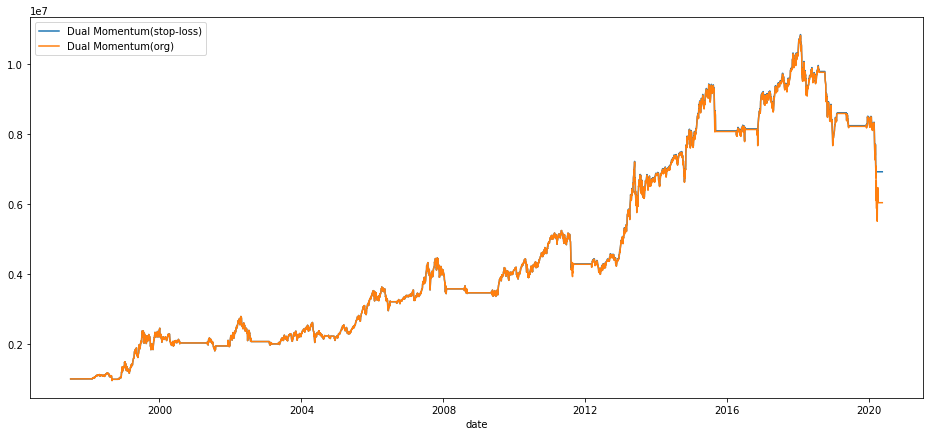

In [9]:
df = pd.DataFrame()
df['Dual Momentum(stop-loss)'] = dm_pos_values_df['total']
df['Dual Momentum(org)'] = dmorg_pos_values_df['total']

plt.rcParams["figure.figsize"] = (16,7)
df.plot()

원래의 듀얼 모멘텀 전략과 비교해보면 (당연하게도)대부분의 구간에서 완전히 일치하는 그래프를 볼 수 있다.
첫 번째 손절매시기인 2011년 8월 9일은 확인 결과 그 다음달 리밸런스 시점에 가격이 약간 상승하여 손절매로인한 방어 효과는 거의 미미했고, 2020년 코로나 대폭락때는 그 손절매 효과가 제법 쏠쏠한 것을 확인할 수 있다.

## 맺음

하한가가 없는 다른 거래소의 종목에 투자하는 경우 아주 극단적인 상황을 대비하기 위한 예외처리는 반드시 필요해 보인다.
물론 실제 거래에서는 손절을 위해 보유한 주식을 전부 던져도 거래가 체결된다는 보장은 없다.